In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset, DownloadManager, Image, load_from_disk, concatenate_datasets
import torch
from torch.utils.data import DataLoader
from diffusers import StableDiffusionPipeline
from typing import Union, List


%matplotlib inline

## Load datasets

In [ ]:
# method used for adding a column called label to a huggingface dataset
def add_label(dataset_row, label):
    dataset_row['label'] = label
    return dataset_row

#### Clothing dataset

Generating train split:   0%|          | 0/14904 [00:00<?, ? examples/s]

outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket


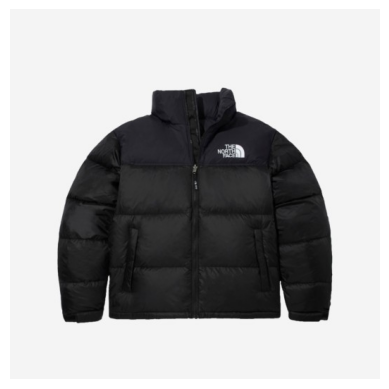

In [2]:
def get_clothes_dataset():
    clothes_dataset = load_dataset("hahminlew/kream-product-blip-captions", split="train") # only has a train split
    return clothes_dataset.map(lambda row: add_label(row, 'clothes'))

clothes_dataset = get_clothes_dataset()
sample = clothes_dataset[0]
clothes_dataset_size = len(clothes_dataset)
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image']) # 525 x 525 pixels

#### Cartoon pixel art dataset

Generating train split:   0%|          | 0/49859 [00:00<?, ? examples/s]

a pixel art character with square black glasses, a hotdog-shaped head and a peachy-colored body on a warm background
49859


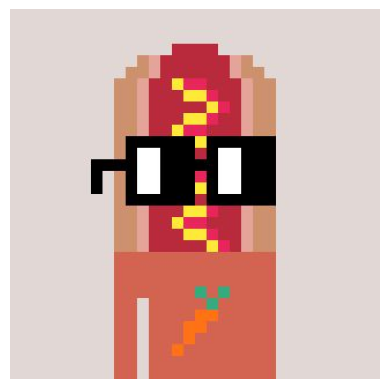

In [5]:
def get_pixelart_dataset(clothes_dataset_size):
    pixelart_dataset = load_dataset('m1guelpf/nouns', split='train') # only has a train split too
    return pixelart_dataset.select(range(clothes_dataset_size)).map(lambda row: add_label(row, 'pixel_art'))

pixelart_dataset = get_pixelart_dataset()
sample = pixelart_dataset[0]
print(sample["text"])
plt.axis('off')
plt.imshow(sample['image']) # 320 x 320 pixels

#### Realistic photograph dataset

In [ ]:
def get_photograph_dataset(clothes_dataset_size):
    dataset_path = './photograph_dataset'

    try:
        photograph_dataset = load_from_disk(dataset_path)
    except FileNotFoundError:
        photograph_dataset = load_dataset('1aurent/unsplash-lite-palette', split='train') # also, this dataset only has train split
        photograph_dataset = photograph_dataset.select(range(clothes_dataset_size))

        def download_image(url: Union[str, List[str]], dl_manager: DownloadManager):
            filenames = dl_manager.download(url)
            # Open, resize, and save the image (overwriting the original)
            # def resize(filename: str):
            #     with PIL.Image.open(filename) as img:
            #         img = img.resize((512, 512), PIL.Image.LANCZOS)
            #         img.save(filename)  # This overwrites the original image file with the resized one
            # if isinstance(filenames, str):
            #     resize(filenames)
            # else:
            #     for filename in filenames:
            #         resize(filename)
            
            return {"image": filenames}
        
        photograph_dataset = photograph_dataset.map(
            function=download_image,
            input_columns=["url"],
            fn_kwargs={
                "dl_manager": DownloadManager(),
            },
            batched=True,
            num_proc=1,
        )
        photograph_dataset = photograph_dataset.cast_column(
            column="image",
            feature=Image(),
        )
        photograph_dataset = photograph_dataset.remove_columns(['url', 'palettes'])
        photograph_dataset = photograph_dataset.rename_column('ai_description', 'text').map(lambda row: add_label(row, 'photographs'))
        photograph_dataset.save_to_disk(dataset_path)
    return photograph_dataset
    

In [ ]:
def collate_fn(batch):
    texts = [item['text'] for item in batch]
    images = [item['image'] for item in batch]
    labels = [item['label'] for item in batch]
    # this tuple is what is returned on each data loader iteration
    return texts, images, labels
    
def get_finetuning_dataloaders(train_split=0.5, val_split=0.1, batch_size=4):
    # train split size is 0.5 for 50% of data by default
    # val split size is 10% of data
    
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
    
    # Split dataset to get finetuning train/val splits
    
    ft_split_clothes = clothes_dataset.train_test_split(train_size=train_split + val_split)
    ft_split_clothes_train_val = ft_split_clothes['train'].train_test_split(test_size=val_split)
    ft_clothes_train, ft_clothes_val = ft_split_clothes_train_val['train'], ft_split_clothes_train_val['test']
    
    ft_split_pixelart = pixelart_dataset.train_test_split(train_size=train_split + val_split)
    ft_split_pixelart_train_val = ft_split_pixelart['train'].train_test_split(test_size=val_split)
    ft_pixelart_train, ft_pixelart_val = ft_split_pixelart_train_val['train'], ft_split_pixelart_train_val['test']
    
    ft_split_photographs = photograph_dataset.train_test_split(train_size=train_split + val_split)
    ft_split_photographs_train_val = ft_split_photographs['train'].train_test_split(test_size=val_split)
    ft_photographs_train, ft_photographs_val = ft_split_photographs_train_val['train'], ft_split_photographs_train_val['test']
    
    # Get dataloaders for ft train/val splits
    ft_clothes_train_loader = DataLoader(ft_clothes_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_clothes_val_loader = DataLoader(ft_clothes_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_pixelart_train_loader = DataLoader(ft_pixelart_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_pixelart_val_loader = DataLoader(ft_pixelart_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    ft_photographs_train_loader = DataLoader(ft_photographs_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    ft_photographs_val_loader = DataLoader(ft_photographs_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return ft_clothes_train_loader, ft_clothes_val_loader, \
        ft_pixelart_train_loader, ft_pixelart_val_loader, \
        ft_photographs_train_loader, ft_photographs_val_loader
    

def get_dataloaders(train_split=0.7, test_split=0.2, val_split=0.1, batch_size=4):
    # clothing dataset is smallest of the three
    clothes_dataset = get_clothes_dataset()
    clothes_dataset_size = len(clothes_dataset)
    pixelart_dataset = get_pixelart_dataset(clothes_dataset_size)
    photograph_dataset = get_photograph_dataset(clothes_dataset_size)
    
    ### Now Get Selection Network Dataloaders ###
    
    # Example split proportions for selection network dataloaders
    split_proportions = {'train': train_split, 'test': test_split, 'validation': val_split}

    # Split datasets
    split_clothes = clothes_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_clothes_val_test = split_clothes['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    clothes_train, clothes_validation, clothes_test = split_clothes['train'], split_clothes_val_test['train'], split_clothes_val_test['test']

    split_pixelart = pixelart_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_pixelart_val_test = split_pixelart['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    pixelart_train, pixelart_validation, pixelart_test = split_pixelart['train'], split_pixelart_val_test['train'], split_pixelart_val_test['test']

    split_photographs = photograph_dataset.train_test_split(test_size=split_proportions['test'] + split_proportions['validation'])
    split_photographs_val_test = split_photographs['test'].train_test_split(test_size=split_proportions['validation'] / (split_proportions['test'] + split_proportions['validation']))
    photographs_train, photographs_validation, photographs_test = split_photographs['train'], split_photographs_val_test['train'], split_photographs_val_test['test']
    
    concatenated_train = concatenate_datasets([clothes_train, pixelart_train, photographs_train])
    concatenated_val = concatenate_datasets([clothes_validation, pixelart_validation, photographs_validation])
    concatenated_test = concatenate_datasets([clothes_test, pixelart_test, photographs_test])
    
    train_loader = DataLoader(concatenated_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    validation_loader = DataLoader(concatenated_val, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(concatenated_test, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, validation_loader, test_loader

### Testing out stable diffusion model

In [5]:
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"


pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# sometimes, clip will flag the image as being nsfw. In this case, the model will produce a completely black image 
# this is harmful for training, so for training purposes we will temporarily disable the nsfw safety checker
pipe.safety_checker = lambda images, clip_input: (images, [False for _ in images]) 
pipe = pipe.to(device)

prompt = "outer, The North Face 1996 Eco Nuptse Jacket Black, a photography of the north face black down jacket"
image = pipe(prompt).images[0]
    

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

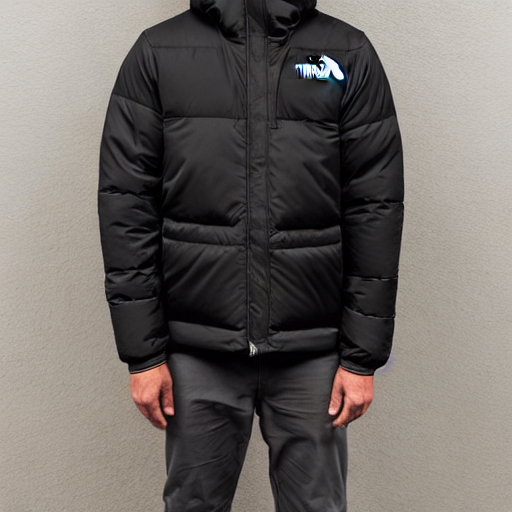

In [6]:
image # 512 x 512 pixel image produced by diffusion model